# Customer Cancellation Intervention
For a subscription-based business, reducing customer churn is critical to maintaining high growth. This project will examine a nearly six month slice of subscription transactions from such a business in an attempt to identify patterns leading to cancellation. The goal is to train a classifier capable of identifying customers at risk of cancellation using details of upcoming subscription transactions.

**A note on vocabulary:** A customer of this business purchases a **kit** containing several different products. Each of these products are then **refilled** before expiration as part of the subscription service.

## Features
1. `RefillNumber`: The ordinality of this transaction in the refill history. For example, `RefillNumber=1` corresponds to a kit's first refill, and the fifth refill will have a `RefillNumber` of `5`.
* `RefillAmount`: The cost of this refill.
* `RefillItems`: The number of items in this refill.
* `AdvancedNotified`: Customers with up-to-date contact information are sent an email 2-4 weeks before their refill is scheduled for delivery. This field indicates which refills were preceded by such a notification.
* `KitType`: A kit's type determines the mix of products contained within it.
* `KitPurchasePrice`: The purchase price of the kit.
* `KitDistributionChannel`: The distribution channel through which the customer purchased the kit. One of `DIRECT`, `DEALER`, or `WEB`.
* `CustomerIsCorporate`: Some customers are associate with each other through a larger organization known as a corporation.
* `CustomerState`: The US state to which the customer belongs.
* `PreviousRefillsAmount`: The sum of the cost of all previous refills for this kit.
* `DaysSinceLastRefill`: The number of days since the last refill.
* `DaysSinceKitPurchase`: The number of days since the kit was purchased.

## Problem Discussion
The target column, `ServiceLevelChange`, can be one of `No change`, `Downgraded`, or `Deactivated` and represents the service level change of the kit in the 45 days following the refill. As such, this is a multiclass classification problem. Moreover, as will be explored below, the classes are heavily unbalanced with nearly 98% of the samples belonging to the `No change` class. The choice of performance metric will therefore be critical, as many common metrics perform poorly with unbalanced classes. Finally, due to data integrity issues, purchase information is not available for many kits and will need to be imputed.

### Performance Metric
It is much more important that the classifier correctly identify the `Downgraded` and `Deactivated` samples than the `No change` samples, as the former two "at-risk" classes require intervention while the latter does not. On the other hand, while hardly desired, it is not such a big failing if the classifier over-assigns samples to these at-risk classes, within rease. As such, the performance metric must prioritize true positives of the at-risk clases. Therefore, the classifier will be judged using two performance metrics: recall and precision, both using the `micro` averaging scheme and ignoring the `No change` class. The recall score exactly fits the problem description above, while precision reflects samples falsely assigned to the at-risk classes. Recall will be the primary metric.

*See the "Next Steps" section of the Conclusion for a potential performance metric based on lifetime customer value.*

In [1]:
# Import refill data
import numpy as np
import pandas as pd
from IPython.display import display
refill_data = pd.read_csv('refill_data.csv')
category_columns = [
    'AdvancedNotified',
    'KitType',
    'KitDistributionChannel',
    'CustomerIsCorporate',
    'CustomerState',
    'ServiceLevelChange'
]
for column in category_columns:
    refill_data[column] = refill_data[column].astype('object')
display(refill_data.head(3))
display(refill_data.describe())
display(refill_data[category_columns].describe())

,RefillNumber,RefillAmount,RefillItems,AdvancedNotified,KitType,KitPurchasePrice,KitDistributionChannel,CustomerIsCorporate,CustomerState,PreviousRefillsAmount,DaysSinceLastRefill,DaysSinceKitPurchase,ServiceLevelChange
0,21,301.50,2,1,G,NaN,NaN,0,CA,3583.55,120,3083,No change
1,22,75.33,4,1,G,NaN,NaN,0,CA,3885.05,68,3151,No change
2,23,301.50,2,0,K,NaN,NaN,0,VA,4661.39,147,3085,No change


,RefillNumber,RefillAmount,RefillItems,KitPurchasePrice,PreviousRefillsAmount,DaysSinceLastRefill,DaysSinceKitPurchase
count,47489.000000,47489.00000,47489.000000,35154.000000,47489.000000,44431.000000,47489.000000
mean,8.759523,223.64987,2.788183,376.466930,1686.721326,119.733497,1914.043378
std,5.656329,164.72680,1.061100,315.602534,1131.503088,105.596982,1809.176829
min,1.000000,29.45000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,75.50000,2.000000,120.800000,705.380000,63.000000,943.000000
50%,8.000000,142.06000,3.000000,333.350000,1691.210000,99.000000,1412.000000
75%,12.000000,322.61000,3.000000,532.100000,2354.540000,154.000000,1945.000000
max,31.000000,1194.06000,16.000000,3144.950000,7272.910000,2872.000000,42464.000000


,AdvancedNotified,KitType,KitDistributionChannel,CustomerIsCorporate,CustomerState,ServiceLevelChange
count,47489,47489,35154,47489,47489,47489
unique,2,20,3,2,57,3
top,0,J,DIRECT,0,CA,No change
freq,25468,22242,27530,41280,8927,46412


In [2]:
# Separate data into features (X) and target (y)
X_raw = refill_data[list(refill_data.columns[:-1])]
y_all = refill_data[refill_data.columns[-1]]
print X_raw.shape
print y_all.shape

(47489, 12)
(47489,)


In [3]:
# Investigate problem severity
from IPython.display import display
print "Total refills: {}".format(y_all.count())
print "Service level changes within 45 days of refill:"
class_count = pd.DataFrame({
    'samples': y_all.value_counts(),
    'percentage': 100*y_all.value_counts()/y_all.count()
})
display(class_count)

Total refills: 47489
Service level changes within 45 days of refill:


,percentage,samples
No change,97.732106,46412
Downgraded,1.981512,941
Deactivated,0.286382,136


Installed disable_autoscroll.py. To use it, type:
  %load_ext disable_autoscroll


/opt/conda/envs/python2/lib/python2.7/site-packages/IPython/core/magics/extension.py:47: UserWarning: %install_ext` is deprecated, please distribute your extension as a python package.
  "as a python package.", UserWarning)


<IPython.core.display.Javascript object>

autoscrolling long output is disabled


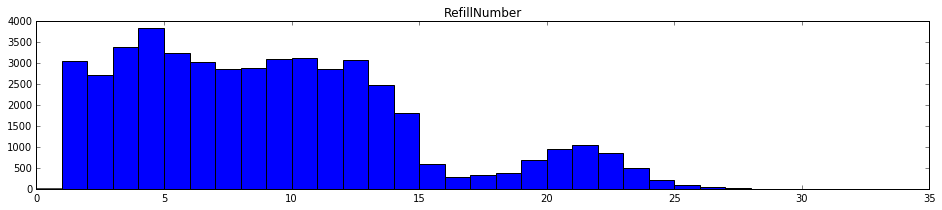

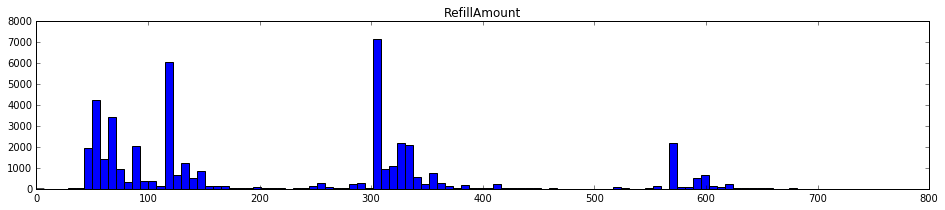

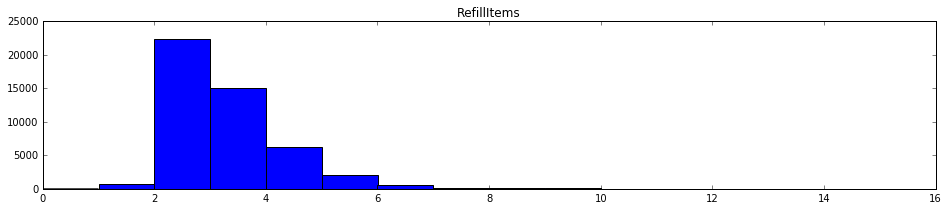

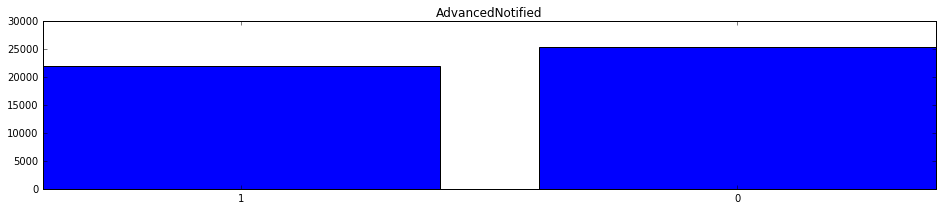

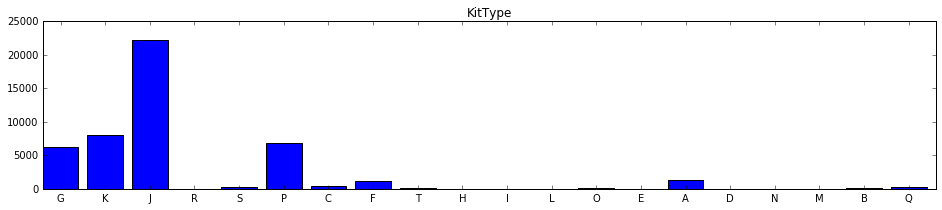

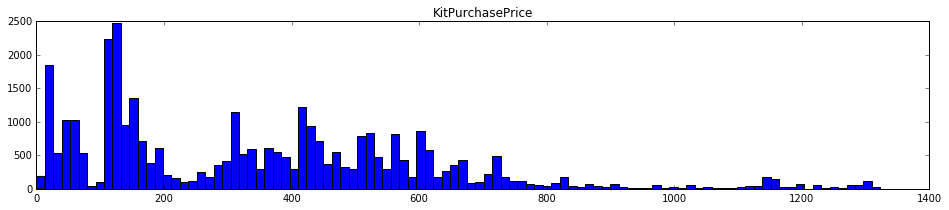

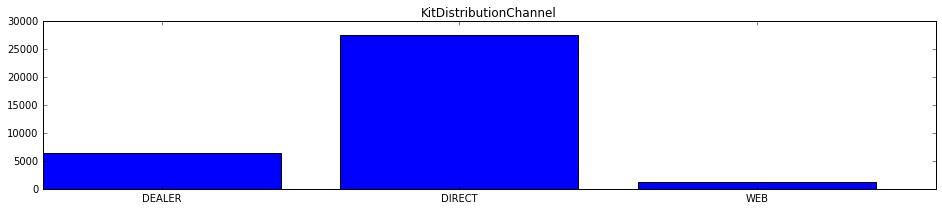

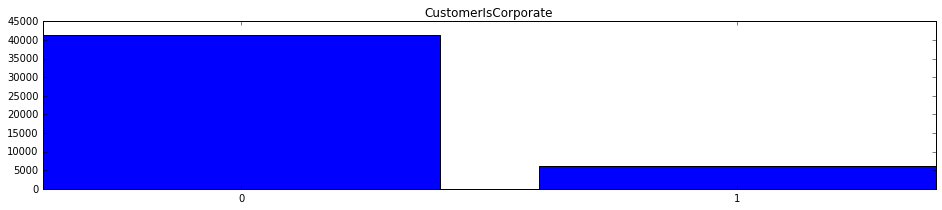

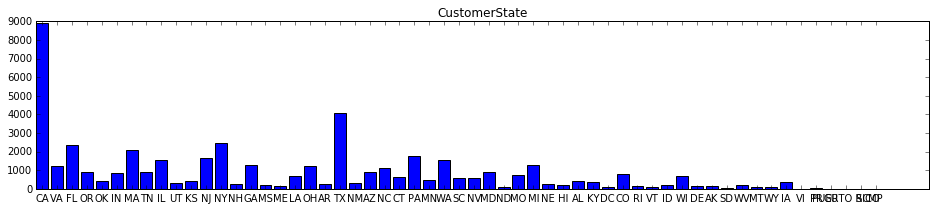

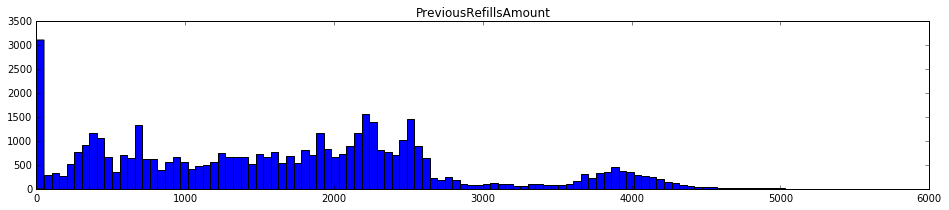

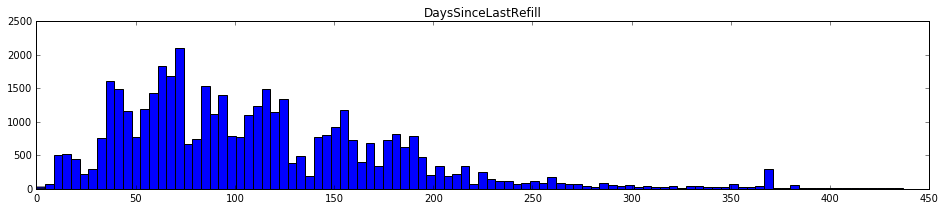

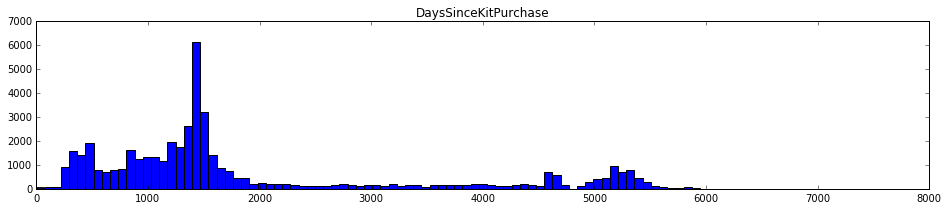

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
%install_ext https://raw.githubusercontent.com/minrk/ipython_extensions/master/extensions/disable_autoscroll.py
%load_ext disable_autoscroll
for col, col_data in X_raw.iteritems():
    plt.figure(figsize=(16,3))
    if col in category_columns:
        values = [x for x in col_data.unique() if x == x]
        index = np.arange(len(values))
        counts = list(col_data[col_data == value].count() for value in values)
        bar_width = 0.8
        
        plt.bar(index, counts, bar_width)
        plt.xticks(index + bar_width/2, values)
    else:
        bins = range(col_data.max() + 1) if len(col_data.unique()) < 100 else 100
        plot_data = [x for x in col_data.values if not np.isnan(x)]
        plt.hist(plot_data, bins=bins, range=[0, min(col_data.max(), col_data.mean() + 3*col_data.std())])
    plt.title(col)
    plt.show()

## Data Discussion
`RefillNumber` is fairly evenly distributed at the lower end, with between 6% and 8% of the samples belonging to each `RefillNumber` value up to 12, after which it drops off sharply. `PreviousRefillsAmount` shares a similar distribution, dropping off after around \$2,500, which indicates a fairly consistent refill price. This is confirmed by examining the distribution of `RefillAmount`, which is heavily concentrated around \$100, \$300, and \$550. Also very consistent is the number of items contained in the refill, with nearly all of the samples having a `RefillItems` value of either 2, 3, or 4.

The distributions of `RefillNumber`, `PreviousRefillsAmount`, and `DaysSinceKitPurchase` seem to indicate that there are two distinct kit groups. Most of the samples belong to kits sold in the past few years. However, there is also a smaller group of long-standing installs. The behavior of these two groups might differ significantly.

Other notes:
* `DaysSinceLastRefill` seems almost normally distributed around 60 days, though it is definitely skewed to the right.
* In contrast, `DaysSinceKitPurchase` is heavily concentrated around 1,500 days.
* Around half of the refills were preceded by a notification.
* Around 60% of the refills belong to kits that were sold directly to the customer.
* Almost half of the samples belong to `KitType` J, and nearly all of the samples belong to `KitType` G, J, K, or P.
* Over one-fifth of the samples belong to customers in California, with Texas coming in second place at around one-tenth. The other states are relatively evenly distributed.

## Feature Preprocessing

In [35]:
# Impute missing values by class
# Impute numerical with mean, categorical with mode
# TODO: Ensure index order is maintained
X_imputed = pd.DataFrame()
results = y_all.unique()
for result in results:
    X_class = X_raw[y_all == result]
    X_class_imputed = pd.DataFrame(index = X_class.index)
    for col, col_data in X_class.iteritems():
        fill_value = col_data.mode()[0] if col_data.dtype == object else col_data.mean()
        X_class_imputed = X_class_imputed.join(col_data.fillna(fill_value))
    X_imputed = X_imputed.append(X_class_imputed, verify_integrity = True)
    
X_all = pd.DataFrame(index = X_imputed.index)
for col, col_data in X_imputed.iteritems():
    # Transform DaysSinceLastRefill to reciprocal, fill NULL with 0
    # TODO: Look for NaN results
    if col == 'DaysSinceLastRefill':
        col_data = X_raw[col].rtruediv(1).fillna(0)
        col_data.name = 'RefillFrequency'
    # Split categorical features into multiple binary columns
    elif col_data.dtype == object and set(col_data.unique()) != set([0,1]):
        col_data = pd.get_dummies(col_data, prefix=col)
    X_all = X_all.join(col_data)
    
X_all.head()

,RefillNumber,RefillAmount,RefillItems,AdvancedNotified,KitType_A,KitType_B,KitType_C,KitType_D,KitType_E,KitType_F,...,CustomerState_VA,CustomerState_VI,CustomerState_VT,CustomerState_WA,CustomerState_WI,CustomerState_WV,CustomerState_WY,PreviousRefillsAmount,RefillFrequency,DaysSinceKitPurchase
0,21,301.50,2,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,3583.55,0.008333,3083
1,22,75.33,4,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,3885.05,0.014706,3151
2,23,301.50,2,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,4661.39,0.006803,3085
3,24,129.40,3,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,4962.89,0.022222,3130
4,2,326.78,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,69.58,0.014925,3128


## Algorithm Selection
Scalability is the name of the game, here. With nearly 48,000 samples on which to train, and more assuredly available in a production environment, the algorithm chosen must scale well in the number of samples. In addition, the algorithm must scale well in the number of features. We've identified 10 features to start with but that might, and probably will, grow quickly as the understanding of customer behavior improves. The number of features will likely never outgrow the number of samples, however.

The final model will be used to predict the result of upcoming refills on demand. A quick prediction time is therefore very important, and will it will only become more important as the customer base grows. Lazy learners would therefore not be suitable for this problem. On the other hand, training time is not a significant factor. As new data becomes available, the model can be retrained asynchronously and pushed to live when ready. Online learners would be ideal in this situation, as the true results of each refill are available after 45 days and the model could then be updated with the new information.

Based on the above, and by consulting the sklearn documentation on choosing an estimator, the following algorithms will be trained and tested:
* Linear SVC
* SGD Classifier
* Decision Trees (including random forest)

In [34]:
# Train classifier
from sklearn.metrics import recall_score, precision_score, make_scorer
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

recall_scorer = make_scorer(recall_score, labels=['Deactivated', 'Downgraded'], average='micro')
precision_scorer = make_scorer(precision_score, labels=['Deactivated', 'Downgraded'], average='micro')
    
results = []
classifiers = [
    LinearSVC(dual=False),
    SGDClassifier(),
    DecisionTreeClassifier(),
    RandomForestClassifier()
]
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, stratify=y_all)
for clf in classifiers:
    classifier = clf.__class__.__name__
    recall = cross_val_score(clf, X_train, y_train, scoring=recall_scorer, n_jobs=-1)
    precision = cross_val_score(clf, X_train, y_train, scoring=precision_scorer, n_jobs=-1)
    results.append([classifier, recall.mean(), precision.mean()])
    
results = pd.DataFrame(
    data = results,
    columns = [
        'classifier',
        'recall',
        'precision'
    ]
)

display(results)

/opt/conda/envs/python2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/python2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/python2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


,classifier,recall,precision
0,LinearSVC,0.000000,0.000000
1,SGDClassifier,0.003484,0.062500
2,DecisionTreeClassifier,0.031323,0.026045
3,RandomForestClassifier,0.002323,0.018750


In [14]:
from sklearn.grid_search import GridSearchCV
from sklearn.svm import LinearSVC
parameters = {
    'C': (0.1, 0.5, 1.0, 1.5, 2.5, 5.0, 7.5, 10),
    'loss': ('hinge', 'squared_hinge'),
    'multi_class': ('ovr', 'crammer_singer')
}
clf = GridSearchCV(LinearSVC(), parameters, scoring=recall_scorer, n_jobs=-1)
clf.fit(X_train, y_train)
print "Best LinearSVC recall: {}".format(clf.best_score_)
print clf.best_params_
precision = cross_val_score(clf.best_estimator_, X_train, y_train, scoring=precision_scorer, n_jobs=-1)
print "Precision: {}".format(precision.mean())

Best LinearSVC recall: 0.470299747149
{'loss': 'squared_hinge', 'C': 1.0, 'multi_class': 'crammer_singer'}
Precision: 0.0218225060069


In [11]:
from sklearn.grid_search import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
parameters = [
    {
        'criterion': ('gini', 'entropy'),
        'max_features': ('sqrt', 'log2', None),
        'max_depth': (3, 4, 5, 6, 7, 8, 9, 10, None),
        'min_samples_split': (0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2)
    }
]
clf = GridSearchCV(DecisionTreeClassifier(), parameters, scoring=recall_scorer, n_jobs=-1)
clf.fit(X_train, y_train)
print "Best DecisionTreeClassifier score: {}".format(clf.best_score_)
print clf.best_params_
precision = cross_val_score(clf.best_estimator_, X_train, y_train, scoring=precision_scorer, n_jobs=-1)
print "Precision: {}".format(precision.mean())

Best DecisionTreeClassifier score: 0.0892452697591
{'max_features': None, 'min_samples_split': 0.2, 'criterion': 'gini', 'max_depth': None}
Precision: 0.0714274405497


In [15]:
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
parameters = [
    {
        'n_estimators': (2, 5, 10, 15, 20, 25, 50, 75, 100),
        'criterion': ('gini', 'entropy'),
        'max_features': ('sqrt', 'log2', None),
        'max_depth': (3, 4, 5, 6, 7, 8, 9, 10, None),
        'min_samples_split': (2, 5, 10, 25, 50, 75, 100, 150, 200, 250, 500, 1000)
    }
]
clf = GridSearchCV(RandomForestClassifier(), parameters, scoring=recall_scorer, n_jobs=-1)
clf.fit(X_train, y_train)
print "Best RandomForestClassifier score: {}".format(clf.best_score_)
print clf.best_params_
precision = cross_val_score(clf.best_estimator_, X_train, y_train, scoring=precision_scorer, n_jobs=-1)
print "Precision: {}".format(precision.mean())

Best RandomForestClassifier score: 0.0255030858219
{'max_features': None, 'min_samples_split': 10, 'criterion': 'entropy', 'max_depth': None, 'n_estimators': 5}
Precision: 0.175949606896


In [8]:
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import SGDClassifier
parameters = [
    {
        'loss': ('hinge', 'log', 'modified_huber', 'squared_hinge'),
        'penalty': ('none', 'l2', 'l1', 'elasticnet'),
        'alpha': (0.0001, 0.001, 0.01),
        'l1_ratio': (0.0, 0.15, 0.3, 0.45, 0.6, 0.75, 0.9, 1.0),
        'fit_intercept': (True, False),
        'n_iter': (1, 5, 10, 50, 100),
        'warm_start': (True, False)
    }
]
clf = GridSearchCV(SGDClassifier(), parameters, scoring=recall_scorer, n_jobs=-1)
clf.fit(X_train, y_train)
print "Best SGDClassifier score: {}".format(clf.best_score_)
print clf.best_params_
precision = cross_val_score(clf.best_estimator_, X_train, y_train, scoring=precision_scorer, n_jobs=-1)
print "Precision: {}".format(precision.mean())

Best SGDClassifier score: 0.485292887622
{'warm_start': True, 'n_iter': 50, 'loss': 'modified_huber', 'l1_ratio': 0.9, 'fit_intercept': True, 'penalty': 'l2', 'alpha': 0.0001}
Precision: 0.0138888888889
